# Data Processing U850/V850
Authors: Teagan King, John Truesdale, Katie Dagon
Last updated: Feb 2023

## Notes
* Files took long time to process --> had been broken into 10 smaller files, then processed, but hopefully python/dask can deal with full file size!
* For RCP8.5 simulation: use 3hr averages for 2086-2100

## Fields needed

### U850/V850

U850, V850 (U and V at 850 mb pressure level) can be created from the full 3d fields (all levels) U and V files along with PS.  I used the
following ncl script to regrid V to 200mb ,500mb, and 850mb levels. I think we just need 850.
/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/uvlev.ncl.

It uses PS from the h3 files and an nco function to interpolate U/V from the model levels to a set of pressure levels.  I would think this
functionality already exists.  I would check with Julia Kent and the ESDS group or maybe start with Katie to see if she knows or has python
scripts for interpolating data from terrain following model levels to specific pressure levels.  In addition to interpolating to a pressure
level my script also calls the ncl function poisson_grid_fill to interpolate reasonable values into areas of high topography that
contain fill values after interpolating to 850mb. There is a python wrapper called gridfill that was created from the ncl
poisson_grid_fill function.  https://ocefpaf.github.io/python4oceanographers/blog/2014/10/20/gridfill/  I've used this python version before and it also works nicely.

It looks like 3hrly mean U,V,T,Q are on the h4 files (has been transferred from globus NERSC HPSS: /home/c/ccsm/csm/b.e13.BRCP85C5CN.ne120_g16.003a/atm/proc/tseries/hour_3/ to casper: /glade/p/cgd/ccr/people/tking/data_processing) and PS is on the h3 files under /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/extend/2085-2100

Update 2/6/23: GeoCAT has now [releasesd an extrapolation feature](https://github.com/NCAR/geocat-comp/releases) in [interp_hybrid_to_pressure](https://github.com/NCAR/geocat-comp/blob/15cf6e2ed7c2b179d7b6acb454b90c6b2d644f2f/src/geocat/comp/interpolation.py#L312).

## Import libraries

In [2]:
import glob
import xarray as xr
import cftime
import geocat.comp as gc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Set up Dask

In [3]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='25GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/local_dask', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P93300313', # Input your project ID here, previously this was known as 'project', now is 'account'
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(40)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/tking/.conda/envs/geocat_comp_env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39766 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/39766/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/39766/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:43038,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/39766/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
# cluster.scale(0) # if you want to scale workers back to 0

## Read in files and set pressure level(s)

In [4]:
# location of PS for input to create U850 and V850
# ls /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/extend/2085-2100/*h3.PS.*Z.nc

# location of U for input to create U850 and V850
# ls /glade/p/cgd/ccr/people/tking/data_processing/*U*
# ls /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/extend/*.U.*Z.nc

# location of V for input to create U850 and V850
# ls /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/extend/2085-2100/*.V.*Z.nc
# ls /glade/p/cgd/ccr/people/tking/data_processing/*V*

# The data is now all in /glade/scratch/tking/cgnet/

In [5]:
# location of data
datadir = '/glade/scratch/tking/cgnet/rcp85_2086_2100/'

ufile_format = '*.U.*.nc' # U files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4, 3hourly avg from 2080-2100
vfile_format = '*.V.*.nc' # V files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4, 3hourly avg from 2080-2100
psfile_format = '*.PS.*.nc' # PS files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3, 3hourly avg from 2080-2100

# desired pressure level:
plevel = 850.0  # hPa

In [6]:
# use glob.glob() to get actual files, and sort in order to retain correctly matching files!
ufilenames = sorted(glob.glob(datadir+ufile_format))
vfilenames = sorted(glob.glob(datadir+vfile_format))
psfilenames = sorted(glob.glob(datadir+psfile_format))

In [7]:
ufilenames

['/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2080010100Z-2080123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2081010100Z-2081123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2082010100Z-2082123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2083010100Z-2083123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2084010100Z-2084123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2085010100Z-2085123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam

In [8]:
vfilenames

['/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2080010100Z-2080123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2081010100Z-2081123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2082010100Z-2082123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2083010100Z-2083123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2084010100Z-2084123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2085010100Z-2085123118Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam

In [9]:
psfilenames

['/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2080010100Z-2080123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2081010100Z-2081123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2082010100Z-2082123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2083010100Z-2083123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2084010100Z-2084123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2085010100Z-2085123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2086010100Z-2086123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2087010100Z-2087123121Z.nc',
 '/glade/scratch/tking/cgnet/rcp85_2086_2100/b.e13.BRCP85C5CN.ne120_g16.

In [10]:
# make new .nc files but replace U/V with U850/V850
unew_files = []
for filename in ufilenames:
    unew_files.append((filename.replace('.U.', '.U850.')).split('/')[-1])

vnew_files = []
for filename in vfilenames:
    vnew_files.append((filename.replace('.V.', '.V850.')).split('/')[-1])

In [11]:
unew_files

['b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2080010100Z-2080123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2081010100Z-2081123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2082010100Z-2082123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2083010100Z-2083123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2084010100Z-2084123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2085010100Z-2085123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2086010100Z-2086123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2087010100Z-2087123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2088010100Z-2088123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2089010100Z-2089123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2090010100Z-2090123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2091010100Z-2091123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2092010100Z-2092123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_

In [12]:
vnew_files

['b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2080010100Z-2080123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2081010100Z-2081123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2082010100Z-2082123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2083010100Z-2083123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2084010100Z-2084123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2085010100Z-2085123118Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2086010100Z-2086123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2087010100Z-2087123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2088010100Z-2088123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2089010100Z-2089123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2090010100Z-2090123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2091010100Z-2091123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.V850.2092010100Z-2092123121Z.nc',
 'b.e13.BRCP85C5CN.ne120_

### Test with the first U file (year 2080)

In [23]:
ufile1 = xr.open_dataset(ufilenames[1], chunks={"time": 100, "ncol":10000}) # adjusting chunks for ~100mb size chunks
psfile1 = xr.open_dataset(psfilenames[1], chunks={"time": 100, "ncol":10000}) # using the same chunk size for consistency

file_1_U = ufile1['U'] # U at each level
file_1_PS = psfile1['PS'] # surface pressure

pref = psfile1['P0'] # reference pressure

# hybrid level coordinates
hyam = ufile1['hyam']
hybm = ufile1['hybm']

In [24]:
# ufile1['t_bot']
# ufile1['phi_sfc']
# ufile1

In [25]:
ufile1

<xarray.Dataset>
Dimensions:       (ncol: 777602, ilev: 31, lev: 30, time: 2920, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time          (time) object 2081-01-01 00:00:00 ... 2081-12-31 21:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    P0            float64 ...
    area          (ncol) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    ...            ...
    nscur         (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(100,), meta=np.ndarray>
    U             (time, lev, ncol) float32 dask.array<chunksize=(100, 30, 10000), meta=np.ndarray>
Attributes: (12/14)
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.BRCP85C5CN.ne120_g16.003a
    title:            UNSET
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /global/project/projectdirs/ccsm1/inputdata/atm/cam/ini...
    topography_file:  /global/project/projectdirs/ccsm1/inputdata/atm/cam/top...
    history:          Thu Aug 13 20:29:10 2020: ncks -F -d time,12, b.e13.BRC...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

In [16]:
file_1_U

<xarray.DataArray 'U' (time: 2920, lev: 30, ncol: 777602)>
dask.array<open_dataset-c6498a144eef6c5235d250a07076eddaU, shape=(2920, 30, 777602), dtype=float32, chunksize=(100, 30, 10000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

In [17]:
file_1_PS

<xarray.DataArray 'PS' (time: 2920, ncol: 777602)>
dask.array<open_dataset-0b402ae81aad665f3faee9124ff6cc86PS, shape=(2920, 777602), dtype=float32, chunksize=(100, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

## Interpolate to 850mb level

In [18]:
pref.values

array(100000.)

In [19]:
# define dummy values for t_bot and phi_sfc
# reasoning for this described in GitHub issue: https://github.com/NCAR/geocat-comp/issues/26
# Hopefully the need for this will be removed soon.
t_bot=xr.DataArray([])
phi_sfc=xr.DataArray([])

In [26]:
# interpolate to get correct grid levels using GeoCAT's interpolate hybrid to pressure function:

plevdata = gc.interpolation.interp_hybrid_to_pressure(file_1_U,  # 3d field U/V (time x lev x ncol)
                                        file_1_PS,  # surface pressure (time x ncol)
                                        hyam, hybm,  # coefficients to calculate pressure at each level
                                        p0=pref.values,  # reference pressure
                                        new_levels=np.array([85000], dtype='float32'),  # interpolate to 850 pressure level
                                        lev_dim=None,  # lev is default
                                        method='log', # use log because pressure falls off logarithmically
                                        
                                        extrapolate=True, # extrapolate below ground values
                                        variable='other',
                                        t_bot=t_bot,  # xarray.DataArray Temperature in Kelvin at the lowest layer of the model.
                                                         # Not necessarily the same as surface temperature.
                                                         # Required if ``extrapolate`` is True.
                                        phi_sfc=phi_sfc  # Geopotential in J/kg at the lowest layer of the model.
                                                         # Not necessarily the same as surface geopotential.
                                                         # Required if ``extrapolate`` is True.
                                        )   

## or add mask in this step

#TODO: implement dask here

In [21]:
plevdata

<xarray.DataArray 'U' (time: 2920, plev: 1, ncol: 777602)>
dask.array<setitem, shape=(2920, 1, 777602), dtype=float32, chunksize=(100, 1, 10000), chunktype=numpy.ndarray>
Coordinates:
  * plev     (plev) float32 8.5e+04
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

In [55]:
plevdata.isel(time=0, plev=0)

<xarray.DataArray 'U' (ncol: 777602)>
dask.array<getitem, shape=(777602,), dtype=float32, chunksize=(10000,), chunktype=numpy.ndarray>
Coordinates:
    plev     float32 8.5e+04
    time     object 2080-01-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

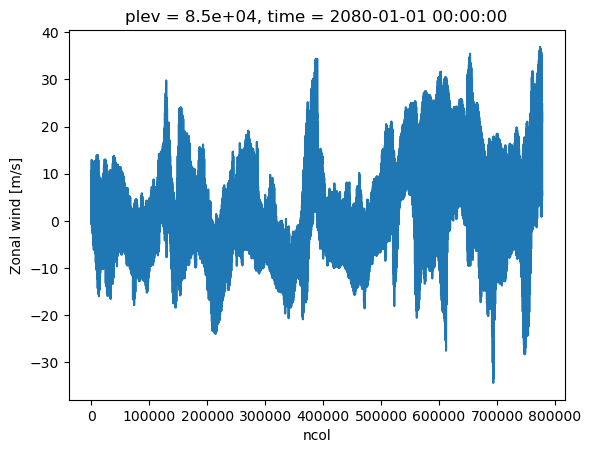

In [23]:
# This is a slow step, but dask workers seem to be effectively distributed
plevdata.isel(time=0).plot()

## Use map file to regrid
From Colin Zarzycki, 12/8/22\
https://github.com/UXARRAY/uxarray/issues/183

In [24]:
## ESMF weightfile
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file='map_ne120_to_0.23x0.31_bilinear.nc'
xwgt=xr.open_dataset(map_path+map_file)
xwgt

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

In [25]:
srclat=xwgt['yc_a']
srclon=xwgt['xc_a']
dstlat=xwgt['yc_b']
dstlon=xwgt['xc_b']
src_grid_dims=xwgt['src_grid_dims'].values
dst_grid_dims=xwgt['dst_grid_dims'].values

print("Src grid dims: {0}, dst grid dims: {1}".format(src_grid_dims, dst_grid_dims))

n_a = xwgt['n_a'].size # col dimension
n_b = xwgt['n_b'].size # row dimension
n_s = xwgt['n_s'].size # nnz dimension

print("Map contains {0} rows, {1} cols and {2} nnz values".format(n_b, n_a, n_s))

rows = xwgt['row'][:] - 1 # row indices (1-based)
cols = xwgt['col'][:] - 1 # col indices (1-based)
nnzvals = xwgt['S'][:] # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


In [26]:
## Create sparse matrix map
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows,cols)),shape=(n_b,n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

#### Note this is the time consuming step (computing plevdata), so sticking to one time index for now

In [27]:
## Now apply map onto a src column vector length n_a to compute vector length n_b
field_target = sparse_map @ plevdata.isel(time=0, plev=0)

In [28]:
## Reshape 1-D vector returned to dst_grid_dims
data_out = np.reshape(field_target, dst_grid_dims, order='F')
print("Reshaped array now has dimensions {0}".format(dst_grid_dims, n_a, n_s))

Reshaped array now has dimensions [1152  768]


In [29]:
## Reshape destination grid to build structured xarray da
lat2d = np.reshape(dstlat.values, dst_grid_dims, order='F')
lon2d = np.reshape(dstlon.values, dst_grid_dims, order='F')

In [30]:
## Build da
da = xr.DataArray(
    data=data_out,
    dims=["x", "y"],
    coords=dict(
        lon=(["x"], lon2d[:,0]),
        lat=(["y"], lat2d[0,:]),
    )
)

In [31]:
da

<xarray.DataArray (x: 1152, y: 768)>
array([[-5.23189497, -5.74085566, -6.42694395, ...,  4.10057305,
         4.29763055,  4.47806507],
       [-5.23189497, -5.72498877, -6.39521044, ...,  4.0657563 ,
         4.28022199,  4.47806507],
       [-5.23189497, -5.70910194, -6.36343706, ...,  4.03095231,
         4.26281981,  4.47806507],
       ...,
       [-5.23189497, -5.78138413, -6.50799991, ...,  4.18866782,
         4.34167836,  4.47806507],
       [-5.23189497, -5.76789572, -6.48102342, ...,  4.15929264,
         4.32699062,  4.47806507],
       [-5.23189497, -5.75438609, -6.4540045 , ...,  4.12992742,
         4.31230787,  4.47806507]])
Coordinates:
    lon      (x) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
    lat      (y) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
Dimensions without coordinates: x, y

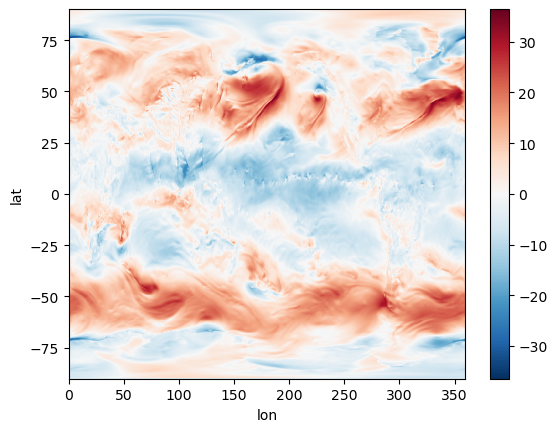

In [32]:
## Simple plot
da.plot(x="lon", y="lat")

## Compute before writing out (slow)

In [ ]:
%%time
plevdata = plevdata.compute()

## Write out / regrid / read in file to visualize
TO DO: figure out how to visualize without remapping...Uxarray?

In [27]:
%%time
plevdata.to_netcdf('/glade/scratch/tking/cgnet/rcp85_2086_2100/U850_2081.nc')

CPU times: user 10min 18s, sys: 21.4 s, total: 10min 39s
Wall time: 1h 20min 25s


In [13]:
%%time
%%bash
module load nco/4.7.9
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/tking/cgnet/rcp85_2086_2100/U850_2080.nc -o /glade/scratch/tking/cgnet/rcp85_2086_2100/U850_2080_regrid.nc


Input #00: /glade/scratch/kdagon/cgnet/U850_2080.nc
Map/Wgt  : /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc
Regridded: /glade/scratch/kdagon/cgnet/U850_2080_regrid.nc


ncks: INFO Reducing user-requested thread number = 2 to maximum thread number allowed = 1
ncks: WARNING NC_DOUBLE version of "_FillValue" attribute for U fails isfinite(), value is NaN, which can cause unpredictable results.
HINT: If arithmetic results (e.g., from regridding) fails or values seem weird, retry after first converting _FillValue to normal number with, e.g., "ncatted -a _FillValue,U,m,f,1.0e36 in.nc out.nc"


CPU times: user 1min 4s, sys: 27 s, total: 1min 31s
Wall time: 11min 30s


In [14]:
# Read back in for plotting
fn=('/glade/scratch/tking/cgnet/U850_2080_regrid.nc')
ds=xr.open_dataset(fn, chunks={"time": 20}) # adjust for chunk size ~100MB

In [16]:
ds['U']

<xarray.DataArray 'U' (time: 2920, plev: 1, lat: 768, lon: 1152)>
dask.array<open_dataset-6443aba25f7ac3924a276093fbe13f91U, shape=(2920, 1, 768, 1152), dtype=float64, chunksize=(20, 1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * plev     (plev) float32 8.5e+04
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Attributes:
    mdims:          1
    units:          m/s
    long_name:      Zonal wind
    cell_methods:   time: mean
    cell_measures:  area: area

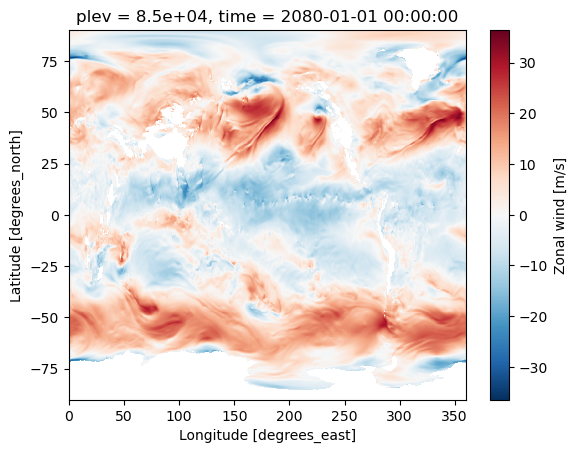

In [17]:
# Quick plot of first time index
ds['U'].isel(time=0).plot();

## Get bottom layer values to fill in missing values in interpolated data

In [19]:
file_1_U.lev.max()

<xarray.DataArray 'lev' ()>
array(992.55609512)
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [20]:
ubot=file_1_U.sel(lev=file_1_U.lev.max())
ubot

<xarray.DataArray 'U' (time: 2920, ncol: 777602)>
dask.array<getitem, shape=(2920, 777602), dtype=float32, chunksize=(100, 10000), chunktype=numpy.ndarray>
Coordinates:
    lev      float64 992.6
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

# Teagan's filling code below:
With the updates to geocat-comp we won't need this

## Mask invalid values in the array

In [13]:
import numpy.ma as ma

# gridfill operates on a masked array: https://numpy.org/doc/stable/reference/maskedarray.generic.html#module-numpy.ma

### use dask here (dask.array.ma: https://docs.dask.org/en/stable/generated/dask.array.ma.masked_array.html)
plevdata_ma_invalid = ma.masked_invalid(plevdata[:, :, :])
plevdata_ma_invalid.mask

### USE XARRAY MASKING to keep labeled dims .where()


# plevdata_ma_invalid = dask.array.ma.masked_invalid(plevdata[:, :, :])
# type(plevdata_ma_invalid)

array([[[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]]])

In [14]:
np.where(plevdata_ma_invalid.mask==True)

(array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 15297,  15304,  15305, ..., 763934, 763935, 765005]))

## Test with a Subset of John's test file:

In [90]:
# there are both true and false values in John's test ufile
# Why is this different from subset of actual data, eg actual data doesn't seem to have True's???
print(plevdata_ma_invalid.mask[0,0,15297])
print(plevdata_ma_invalid.mask[0,0,0])

True
False


In [41]:
plevdata_subset_tnf=plevdata_ma_invalid[0,0,15295:15300]

print(plevdata_subset_tnf)

# ubot is different dimensions than plevdata_ma_invalid b/c only has zeroeth level...
ubot_subset_tnf=ubot[0,15295:15300]
print(ubot_subset_tnf.values)

[-4.09454230957591 -3.2498493224813534 -- -4.144254232261338
 -4.551732974980913]
[-27.909664 -27.89686  -27.886927 -27.615683 -27.605026]


In [50]:
ubot_masked = ma.masked_where(~plevdata_subset_tnf.mask, ubot[0,15295:15300])
# plevdata_subset_tnf.mask

[-- -- -27.886926651000977 -- --]


In [57]:
# plv_subset_masked_w_ubot = ubot_masked + plevdata_subset_tnf
# print(plv_subset_masked_w_ubot)

print(plevdata_subset_tnf)
print(ubot_masked)

merged = np.ma.where(plevdata_subset_tnf.mask, ubot_masked, plevdata_subset_tnf)
print(merged)

[-4.09454230957591 -3.2498493224813534 -- -4.144254232261338
 -4.551732974980913]
[-- -- -27.886926651000977 -- --]
[ -4.09454231  -3.24984932 -27.88692665  -4.14425423  -4.55173297]


## Test with John's test file:

In [15]:
ubot=file_1_U[:,29,:]

In [16]:
# print("file_1_U", file_1_U.shape)
# in going to plevdata, the shape changes such that only one level is present because it's at U850...
# print("plevdata is 3 time slices, 1 level, 777602 columns", plevdata.shape)
# print("plevdata_ma_invalid", plevdata_ma_invalid.shape)
# print("ubot is 3 time slices, 777602 columns", ubot.shape)
# print("merged_full is 3 time slices, 777602 columns", merged_full.shape)

ubot_masked_full = ma.masked_where(~plevdata_ma_invalid[:,0,:].mask, ubot)
merged_full = np.ma.where(plevdata_ma_invalid[0].mask, ubot_masked_full, plevdata_ma_invalid[0])
# print(merged_full)

# all_levels_merged_full=np.asarray([])
# for level in range(0,3):
#     ubot_masked_full = ma.masked_where(~plevdata_ma_invalid[:,level,:].mask, ubot)
#     merged_full = np.ma.where(plevdata_ma_invalid[:,level,:].mask, ubot_masked_full, plevdata_ma_invalid[:,level,:])
#     # print(merged_full)
#     all_levels_merged_full.append(merged_full)

In [17]:
# np.where(merged_full.mask==True)
# merged_full should always have a value, but remaining mask could help us mark what was ubot vs orig val

### trying to find where mask is true on original files...

In [20]:
## THIS CELL IS TAKING HOURS TO RUN... all masks are empty...
# plevdata: 'U'  time: 3plev: 1ncol: 777602

import numpy.ma as ma

# plevdata_ma_invalid = ma.masked_invalid(plevdata[0, 0, :]) # change to :,0,: to just use level 0 and all times
# plevdata_ma_invalid.mask

# plevdata_ma_invalid_subset = plevdata_ma_invalid[0,0,:]
# plevdata_ma_invalid_subset.mask

# plevdata_ma_invalid_first_half = ma.masked_invalid(plevdata[0, 0, 3000:17602]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_first_half.mask
# np.where(plevdata_ma_invalid_first_half==True)

# # could we instead look for lat/lon of fill values and check lat/lon of plevdata?
# # but it needs to be regridded...

# plevdata_ma_invalid_2_half = ma.masked_invalid(plevdata[0, 0, 17602:90000]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_2_half.mask
# np.where(plevdata_ma_invalid_2_half==True)
# # plevdata_ma_invalid.data.shape
# # plevdata.shape

# plevdata_ma_invalid_3_half = ma.masked_invalid(plevdata[0, 0, 90000:300000]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_2_half.mask
# np.where(plevdata_ma_invalid_3_half==True)
# # plevdata_ma_invalid.data.shape
# # plevdata.shape

# plevdata_ma_invalid_4_half = ma.masked_invalid(plevdata[0, 0, 300000:500000]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_2_half.mask
# np.where(plevdata_ma_invalid_4_half==True)
# # plevdata_ma_invalid.data.shape
# # plevdata.shape

# plevdata_ma_invalid_5_half = ma.masked_invalid(plevdata[0, 0, 500000:700000]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_2_half.mask
# np.where(plevdata_ma_invalid_5_half==True)
# # plevdata_ma_invalid.data.shape
# # plevdata.shape

# plevdata_ma_invalid_6_half = ma.masked_invalid(plevdata[0, 0, 700000:777601]) # change to :,0,: to just use level 0 and all times
# # plevdata_ma_invalid_2_half.mask
# np.where(plevdata_ma_invalid_6_half==True)
# # plevdata_ma_invalid.data.shape
# # plevdata.shape

<xarray.DataArray 'U' (time: 3, plev: 1, ncol: 777602)>
dask.array<_vertical_remap, shape=(3, 1, 777602), dtype=float32, chunksize=(3, 1, 50), chunktype=numpy.ndarray>
Coordinates:
  * plev     (plev) float32 8.5e+04
  * time     (time) object 2084-01-01 03:00:00 ... 2084-01-01 09:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

## Fill with gridfill interpolation

This is an alternative option to filling with UBOT

In [23]:
# conda install -c conda-forge gridfill
# https://github.com/ajdawson/gridfill
# https://ocefpaf.github.io/python4oceanographers/blog/2014/10/20/gridfill/

In [24]:
# # poisson_grid_fill in nans
# import gridfill
# from gridfill import fill

In [25]:
# # may also have to crop out first few values if strange values

# # test to see if gridfill works:
# filled, converged = fill(plevdata_ma_invalid, 2, 0, 0.001, relax=0.6, itermax=4000, initzonal=False, cyclic=False, verbose=True)
# # relaxation converged w/ relax=0.6 and itermax=5000

[0] relaxation converged (3672 iterations with maximum residual 9.998e-04)


## create netCDF file

In [1]:
# if you do want to overwrite file, need to remove file first

In [ ]:
# rm /glade/scratch/tking/cgnet/test_filled.nc

In [18]:
# make a netcdf file
from netCDF4 import Dataset
import os
from datetime import datetime

# CHANGE TO WITHIN FOR STATEMENT WITH ALL FILES ONCE WORKING ON MULTIPLE!
# filename_to_create = '/glade/scratch/tking/cgnet/'+unew_files[0]
filename_to_create = '/glade/scratch/tking/cgnet/ubot_filled.nc'
input_data = merged_full
# input_data = filled
# input_data = merged_full

def create_U850_nc_file(filename_to_create, input_data):
    """Create netCDF file for U850 with a particular filename and data to input"""
    if os.path.exists(filename_to_create):
        print('warning, path exists already! not overwriting')
    else:
        ncfile = Dataset(filename_to_create, mode='w', format='NETCDF4_CLASSIC')
        lat_dim = ncfile.createDimension('time', 3)
        lon_dim = ncfile.createDimension('plev', 1)
        # lon_dim = ncfile.createDimension('plev', 30)
        time_dim = ncfile.createDimension('ncol', 777602)

        # add data to netcdf file under 'U850' or 'V850'
        plev_var = ncfile.createVariable('U850',np.float64,('time','plev','ncol')) # unlimited dimension is leftmost
        plev_var.units = 'hPa'
        plev_var.standard_name = 'zonal_wind_850hPa'

        plev_var[:,:,:] = input_data

        # other global attributes needed for netcdf files:
        data_title = "3-hr averaged/Zonal Wind/850 hPa"
        data_summary = "Create input for ClimateNet application, Poisson Fill for NaNs"
        data_creator = "Teagan King, tking@ucar.edu"
        cesm_contact = "Teagan King, tking@ucar.edu"
        data_script = "jupyter notebook at /glade/u/home/tking/cgnet/Data_Processing.ipynb"
        source_file =  ufilenames[0] # ufilename+" and "+pfilename
        conventions = "CF 1.0"
        creation_date = datetime.today().strftime('%Y-%m-%d')

        # actually add this info into file...
        ncfile.title = data_title
        ncfile.summary = data_summary
        ncfile.creator = data_creator
        ncfile.contact = cesm_contact
        ncfile.script = data_script
        # ncfile.source = source_file
        ncfile.conventions = conventions
        ncfile.creation_date = creation_date
        
        ncfile.close()

        print("{} has been written".format(filename_to_create))

create_U850_nc_file(filename_to_create, input_data)

In [31]:
# types of data that can go in nc file:
print(type(merged_full))
print(type(filled))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ndarray'>


## remap and view netcdf file-- commands for casper terminal

In [ ]:
# ncremap -m /glade/scratch/jet/tking/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/tking/cgnet/test_filled.nc -o /glade/scratch/tking/cgnet/test_filled_regridded.nc
# ncview /glade/scratch/tking/cgnet/test_filled_regridded.nc

# ncremap -m /glade/scratch/jet/tking/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/tking/cgnet/ubot_filled.nc -o /glade/scratch/tking/cgnet/ubot_filled_regridded.nc
# ncview /glade/scratch/tking/cgnet/ubot_filled_regridded.nc

In [ ]:
# !ncdump -h '/glade/scratch/tking/cgnet/b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.U850.2097010100Z-2097123121Z.nc'